In [12]:
# All imports required

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [6]:
print(f"Pytorch version: {torch.__version__}")

print(f"Is MPS (Metal performance shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Pytorch version: 2.3.1
Is MPS (Metal performance shader) built? True
Is MPS available? True
Using device: mps


In [10]:
x = torch.rand(size=(3,4)).to(device)
x

tensor([[0.9893, 0.4032, 0.5454, 0.2932],
        [0.9528, 0.8583, 0.7203, 0.7192],
        [0.0122, 0.5103, 0.1257, 0.4184]], device='mps:0')

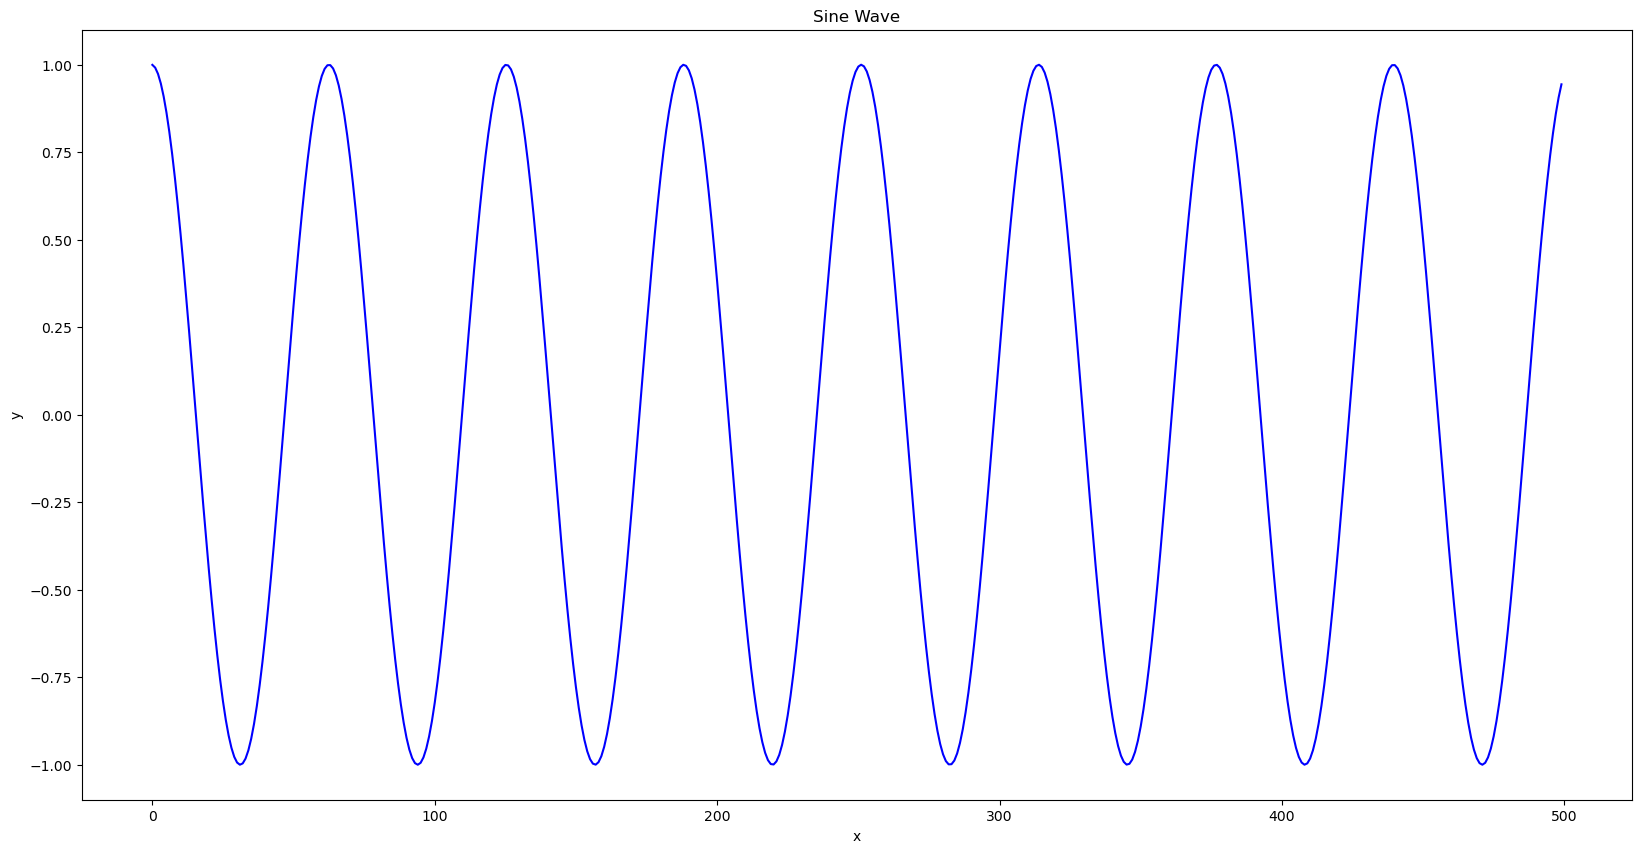

In [20]:
# Initialize number of samples(n), length of each sample(l) and width of the sine wave(t).
n = 50
l = 500
t = 10

x = np.empty((n, l), np.float32)
x[:] = np.array(range(l)) + np.random.randint(-4*t, 4*t, n).reshape(n, 1)
y = np.sin(x/1.0/t).astype(np.float32)

plt.figure(figsize=(20,10))
plt.title("Sine Wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(np.arange(x.shape[1]), y[0,:], 'blue', linewidth=1.5)
plt.show()

In [ ]:
# Using LSTM 

class LSTMpred(nn.Module):
    def __init__(self, n_hidden=69):
        super(LSTMpred, self).__init__()
        self.n_hidden = n_hidden
        self.lstm = nn.LSTMCell(1, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)

    def forward(self, x, future=0):
        output = []
        n_samples = x.size(0)
        
        hid_state = torch.zeroes(n_samples, self.n_hidden, dtype=torch.float32)
        cell_state = torch.zeroes(n_samples, self.n_hidden, dtype=torch.float32)
        
        for input_t in x.split(1, dim=1):
            hid_state, cell_state = self.lstm(input_t, (hid_state, cell_state))
            preds = self.linear(hid_state)
            output.append(preds)

        for i in range(future):
            hid_state, cell_state = self.lstm(preds, (hid_state, cell_state))
            preds = self.linear(hid_state)
            output.append(preds)

        output = torch.cat(output, dim=1)
        return output

if __name__ == "__main__":
    # Shape of the arrays: y = 50, 500
    train_input = torch.from_numpy(y[3:, :-1]) # shape: 47, 499
    train_target = torch.from_numpy(y[3:, 1:]) # Shape: 47, 499
    test_input = torch.from_numpy(y[:3, :-1]) # Shape: 3, 499
    test_target = torch.from_numpy(y[:3, 1:]) # Shape: 3, 499

    model = LSTMpred()
    criterion = nn.MSELoss()
    optimizer = optim.LBFGS(model.parameters(), lr=0.02)

    n_steps = 100
    for i in range(n_steps):
        print(f"Step {i}")

        def close():
            optimizer.zero_grad()
            out = model(train_input)
            loss = criterion(out, train_target)
            print(f"Loss: {loss.item()}")
            loss.backward()
            return loss
        optimizer.step(close)

        with torch.no_grad():
            future = 500
            pred = model(test_input, future=future)
            loss = criterion(pred[:, :-future], test_target)
            print(f"Test Loss: {loss.item()}")
            y = pred.detach().numpy()

            plt.figure(figsize=(20,10))
            plt.title(f"Step {i+1}")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)

            shape = train_input.shape[1]
            def draw(y_i, color):
                plt.plot(np.arange(n), y_i[:n], color, linewidth=1.5)
                plt.plot(np.arange(n, n + future), y_i[n:], color + ":", linewidth=1.5)
            draw(y[0], 'r')
            draw(y[1], 'g')
            draw(y[2], 'b')

            plt.savefig("predicted_sine%d.pdf"%i)
            plt.close()